## Import library

In [89]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import torch.nn.functional as F
import warnings
from pyplnoise import PinkNoise
from tqdm import tqdm
from plot_model import *
from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')
import gc

import vitaldb
import random
import matplotlib.pyplot as plt
# Import additional required libraries
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from math import sqrt
import ml_insights as mli
# Perform Fisher's exact test between filtered_y_test and filtered_p_test_binary
from scipy.stats import fisher_exact

from torch.utils.data.sampler import BatchSampler, WeightedRandomSampler

if torch.cuda.is_available():
    torch.cuda.empty_cache()

from torch.utils.data import Dataset
# Import necessary libraries


    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEGLEN = 2000 #21378  
MAX_CASES = 100
C=6
SEED = 1

adj = torch.zeros(6, 6)
adj[adj == 0] = 0.5
adj[0, 1] = adj[1, 0] = 1  # L1 <-> L2
adj[0, 4] = adj[4, 0] = 1  # L1 <-> L
adj[1, 4] = adj[4, 1] = 1  # L2 <-> L
adj[2, 3] = adj[3, 2] = 1  # R1 <-> R2
adj[2, 5] = adj[5, 2] = 1  # R1 <-> R
adj[3, 5] = adj[5, 3] = 1  # R2 <-> R
adj += torch.eye(6)

D = torch.sum(adj, dim=1)
D_sqrt_inv = torch.diag(torch.pow(D, -0.5))
adj = torch.mm(torch.mm(D_sqrt_inv, adj), D_sqrt_inv)
adj = adj.to(device)
BATCH=16

In [90]:
def clear_memory():
    """Clear memory and GPU cache"""
    gc.collect()
    torch.cuda.empty_cache()
    
class ChunkedDataset(Dataset):
    def __init__(self, X_data, ages, sexes, labels):
        self.X_data = X_data        # Memory-mapped array
        self.ages = ages
        self.sexes = sexes
        self.labels = labels
    
    def __len__(self):
        return len(self.X_data)
    
    def __getitem__(self, idx):
        # Get the original index
        # Load just this one sample
        X = torch.tensor(self.X_data[idx], dtype=torch.float32)
        age = torch.tensor([self.ages[idx]], dtype=torch.float32)
        sex = torch.tensor([self.sexes[idx]], dtype=torch.float32)
        label = torch.tensor([self.labels[idx]], dtype=torch.float32)
        return X, age, sex, label
    
class GraphConvolution(nn.Module):
    """
    Simple GCN layer.
    """
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def forward(self, input, adj):
        support = torch.matmul(input, self.weight)
        output = torch.matmul(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output
        
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return x
    
class CombinedGCNCNN(nn.Module):
    def __init__(self, adj):
        super(CombinedGCNCNN, self).__init__()
        
        nfeat = SEGLEN  # Initial feature number (equal to the sequence length)
        nhid = 100     # Number of hidden units
        nclass = SEGLEN # Output feature number (can be kept same as nfeat for simplicity)
        dropout = 0.3  # Dropout rate

        self.gcn = GCN(nfeat=nfeat, nhid=nhid, nclass=nclass, dropout=dropout)
        self.adj = adj
        
        # Your original CNN model
        self.conv1 = nn.Conv1d(C, 32, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm1d(32)  # Set track_running_stats=False for batch size 1
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm1d(64)  # Set track_running_stats=False for batch size 1
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2)
        self.bn3 = nn.BatchNorm1d(128)  # Set track_running_stats=False for batch size 1
        self.fc1 = nn.Linear(128 * (SEGLEN // 8), 256) # Updated the size due to stride=2 in all conv layers
        self.bn_fc1 = nn.BatchNorm1d(256)  # Set track_running_stats=False for batch size 1
        self.fc2 = nn.Linear(256+2, 1)
        self.relu = nn.ReLU()
        
        # Transformer Layers
        self.embedding_dim = 128
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=self.embedding_dim, nhead=4, dim_feedforward=256, dropout=0.2, batch_first=True), # 0.2->0.25
            num_layers=2)
        
    def forward(self, x, age, sex, adj):
        # GCN
        B, C, L = x.shape
        gcn_x = x.view(B, L, C).permute(0, 2, 1) # Reshape to [batch_size, num_nodes, num_features]
        gcn_out = self.gcn(gcn_x, self.adj)
        gcn_out = gcn_out.view(B, C, L)  # Directly reshape to target dimensions

        # Combine
        enhanced_x = x + gcn_out

        # Pass through CNN
        x = self.relu(self.conv1(enhanced_x))
        if B>1:
            x = self.bn1(x)  # BatchNorm now works with batch size 1
        else:
            x = x
        
        x = self.relu(self.conv2(x))
        if B>1:
            x = self.bn2(x)  # BatchNorm now works with batch size 1
        else:
            x = x
        
        x = self.relu(self.conv3(x))
        if B>1:
            x = self.bn3(x)  # BatchNorm now works with batch size 1
        else:
            x = x
        
        # Reshape for Transformer
        x = x.permute(0, 2, 1)  # Transformer expects [batch, seq_len, features] with batch_first=True
        
        # Pass through Transformer Encoder
        x = self.transformer_encoder(x)
        
        # Flatten for the FC layers
        x = x.permute(0, 2, 1)  
        x = x.reshape(x.size(0), -1)
        
        # Apply FC layers
        x = self.relu(self.fc1(x))
        if B>1:
            x = self.bn_fc1(x)  # BatchNorm now works with batch size 1
        else:
            x = x
            
        x = self.fc2(torch.cat([x, age, sex], dim=1))
        x = torch.sigmoid(x)

        return x

def set_seeds(seed=SEED):
    """Set seeds for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    
## Youden index
def youden(y_true, y_score):
    # Convert inputs to numpy arrays if they aren't already
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    
    # Ensure inputs are 1D arrays
    y_true = y_true.ravel()
    y_score = y_score.ravel()
    
    try:
        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        
        # Add safety check for empty thresholds
        if len(thresholds) == 0:
            print("Warning: No thresholds found")
            return 0.5
            
        # Calculate Youden's J statistic
        J = tpr - fpr
        
        # Find the index of the maximum J value
        idx = np.argmax(J)
        
        # Return the threshold at that index
        return thresholds[idx]
    except Exception as e:
        print(f"Error in Youden calculation: {str(e)}")
        return 0.5

def bootstrap_ci(y_true, y_pred, y_pred_binary, n_bootstraps=4000, alpha=0.05):
    n_samples = len(y_true)
    results = {
        'AUROC': [],
        'AUPRC': [],
        'F1': [],
        'Accuracy': [],
        'Brier': [],
        'ICI': []
    }
    
    for _ in range(n_bootstraps):
        indices = np.random.choice(n_samples, n_samples, replace=True)
            
        # Get bootstrap samples
        boot_y_true = y_true[indices]
        boot_y_pred = y_pred[indices]
        boot_y_pred_binary = y_pred_binary[indices]
        
        # Calculate metrics

        results['AUROC'].append(roc_auc_score(boot_y_true, boot_y_pred))
        results['AUPRC'].append(average_precision_score(boot_y_true, boot_y_pred))
        results['F1'].append(f1_score(boot_y_true, boot_y_pred_binary))
        results['Accuracy'].append(accuracy_score(boot_y_true, boot_y_pred_binary))
        results['Brier'].append(brier_score_loss(boot_y_true, boot_y_pred))
        results['ICI'].append(integrated_calibration_index(boot_y_true, boot_y_pred))
    
    # Calculate confidence intervals
    ci = {}
    for metric, values in results.items():
        # Filter out any NaN values that might have occurred
        values = np.array(values)
        values = values[~np.isnan(values)]
        if len(values) > 0:
            lower = np.percentile(values, alpha/2 * 100)
            upper = np.percentile(values, (1 - alpha/2) * 100)
            ci[metric] = (lower, upper)
        else:
            ci[metric] = (np.nan, np.nan)
    
    return ci

# Calculate Brier score and ICI
def brier_score_loss(y_true, y_pred):
    """
    Calculate Brier score loss between true labels and predicted probabilities
    Lower values indicate better calibrated predictions (0 is perfect)
    """
    return np.mean((y_true - y_pred) ** 2)

def integrated_calibration_index(y_true, y_pred, n_bins=100):
    """
    Calculate integrated calibration index (ICI)
    Lower values indicate better calibration (0 is perfect)
    """
    # Sort predictions and corresponding true values
    sort_idx = np.argsort(y_pred)
    y_pred_sorted = y_pred[sort_idx]
    y_true_sorted = y_true[sort_idx]
    
    # Calculate calibration curve using moving average
    window = len(y_true) // n_bins
    if window < 1:
        window = 1
    
    calibration_curve = np.array([
        np.mean(y_true_sorted[max(0, i-window):min(len(y_true), i+window)])
        for i in range(len(y_true))
    ])
    
    # Calculate absolute difference between predictions and calibration curve
    ici = np.mean(np.abs(y_pred_sorted - calibration_curve))
    return ici

## Preprocessing

In [5]:
x1= pd.read_csv('eeg_rid_supreme_sampled.csv')
x2= pd.read_csv('delirium_old.csv')
birthdate_map = dict(zip(x2['연구별 환자 ID'], x2['생년월일']))
sex_map = dict(zip(x2['연구별 환자 ID'], x2['성별']))
x1['생년월일'] = x1['hid'].map(birthdate_map)
x1['성별'] = x1['hid'].map(sex_map)
x1 = x1.rename(columns={'성별': 'sex'})
x1['sex'] = x1['sex'].map({'M': 1, 'F': 0})
x1['dtstart'] = pd.to_datetime(x1['dtstart'])
x1['생년월일'] = pd.to_datetime(x1['생년월일'])
x1['age'] = (x1['dtstart'] - x1['생년월일']).dt.days // 365

chs = ['ROOT/EEG_L1', 'ROOT/EEG_L2', 'ROOT/EEG_R1', 'ROOT/EEG_R2', 'ROOT/EEG_L', 'ROOT/EEG_R']
x = np.array([])
y = np.array([])
c = np.array([])
f = np.array([])
a = np.array([])  # Array for age
s = np.array([])  # Array for sex
p = np.array([])

EXTRACT_SIZE= 20

for idx in tqdm(range(len(x1))):
    try:
        vf = vitaldb.VitalFile('data/'+x1.loc[idx,'filename']+'.vital')
            
        wf_list = []
        for ch in chs:
            wf_single = vf.to_numpy(ch, 1/vf.trks[ch].srate, return_timestamp=False)
            wf_list.append(wf_single)
        wf = np.column_stack(wf_list)  # Concatenate along columns to get (N,6) shape

        try:
            psi_raw = vf.to_numpy('ROOT/SR', 1/vf.trks['ROOT/SR'].srate, return_timestamp=False).ravel()
            t_orig = np.arange(len(psi_raw)) / vf.trks['ROOT/SR'].srate
            t_new = np.linspace(0, t_orig[-1], len(wf))
            psi = np.interp(t_new, t_orig, psi_raw)
        except:
            psi = np.full(len(wf), np.nan)

        # Rest of the processing code remains the same
        # Get sampling rate from first channel
        srate = vf.trks[chs[0]].srate
        # Calculate window size (120 seconds * sampling rate)
        window_size = int(srate * 120)
        
        # Calculate mean and std of the entire waveform
        total_mean = np.nanmean(wf)
        total_std = np.nanstd(wf)

        # Initialize arrays to store only the best EXTRACT_SIZE chunks
        best_chunks = []
        best_psi_chunks = []
        best_z_scores = []
        
        # Iterate through all possible windows
        stride = int(srate*60)  # Check every 10th position
        for i in range(0, len(wf) - window_size + 1, stride):
            chunk = wf[i:i+window_size]
            psi_chunk = np.nanmean(psi[i:i+window_size])
            if not np.isnan(chunk).any():
                chunk_mean = np.mean(chunk)
                z_score = abs((chunk_mean - total_mean) / total_std)
                
                # If we haven't collected EXTRACT_SIZE chunks yet, append
                if len(best_chunks) < EXTRACT_SIZE:
                    best_chunks.append(chunk)
                    best_z_scores.append(z_score)
                    best_psi_chunks.append(psi_chunk)
                    # Sort if we've reached EXTRACT_SIZE
                    if len(best_chunks) == EXTRACT_SIZE:
                        indices = np.argsort(best_z_scores)
                        best_chunks = [best_chunks[i] for i in indices]
                        best_z_scores = [best_z_scores[i] for i in indices]
                        best_psi_chunks = [best_psi_chunks[i] for i in indices]
                # Otherwise, check if this chunk is better than our worst chunk
                elif z_score < best_z_scores[-1]:
                    best_chunks[-1] = chunk
                    best_z_scores[-1] = z_score
                    best_psi_chunks[-1] = psi_chunk
                    # Re-sort the arrays
                    indices = np.argsort(best_z_scores)
                    best_chunks = [best_chunks[i] for i in indices]
                    best_z_scores = [best_z_scores[i] for i in indices]
                    best_psi_chunks = [best_psi_chunks[i] for i in indices]

        if len(best_chunks) < EXTRACT_SIZE:
            continue
        selected_chunks = np.array(best_chunks)
        selected_psi_chunks = np.array(best_psi_chunks)
        if selected_chunks.shape[1] != 21378:
            continue
            
        # Extend x with new chunks (3D)
        if x.size == 0:
            x = selected_chunks
        else:
            x = np.vstack((x, selected_chunks))

        if p.size ==0:
            p = selected_psi_chunks
        else:
            p = np.vstack((p, selected_psi_chunks))

        # Extend y with labels
        new_labels = np.array([x1.loc[idx,'label']] * EXTRACT_SIZE)
        if y.size == 0:
            y = new_labels
        else:
            y = np.concatenate((y, new_labels))

        # Extend c with hospital IDs
        new_hids = np.array([x1.loc[idx,'hid']] * EXTRACT_SIZE)
        if c.size == 0:
            c = new_hids
        else:
            c = np.concatenate((c, new_hids))

        # Extend f with filenames
        new_files = np.array([x1.loc[idx,'filename']] * EXTRACT_SIZE)
        if f.size == 0:
            f = new_files
        else:
            f = np.concatenate((f, new_files))

        # Extend a with age values
        new_ages = np.array([x1.loc[idx,'age']] * EXTRACT_SIZE)
        if a.size == 0:
            a = new_ages
        else:
            a = np.concatenate((a, new_ages))
            
        # Extend s with sex values
        new_sexes = np.array([x1.loc[idx,'sex']] * EXTRACT_SIZE)
        if s.size == 0:
            s = new_sexes
        else:
            s = np.concatenate((s, new_sexes))
    except FileNotFoundError:
        print(f"File not found: {x1.loc[idx,'filename']}")  
        continue
    except Exception as e:
        print(f"Error processing file {x1.loc[idx,'filename']}: {str(e)}")
        continue

100%|██████████| 4461/4461 [36:42:48<00:00, 29.63s/it]   


In [6]:
# Reshape x to swap 2nd and 3rd dimensions
x = np.transpose(x, (0, 2, 1))
# Save arrays to files
np.save('X.npy', x)
np.save('Y.npy', y)
np.save('C.npy', c)
np.save('F.npy', f)
np.save('A.npy', a)
np.save('S.npy', s)
np.save('P.npy', p)
print(f"Saved arrays with shapes: X:{x.shape}, Y:{y.shape}, C:{c.shape}, A:{a.shape}, S:{s.shape}, F:{f.shape}, P:{p.shape}")

Saved arrays with shapes: X:(68880, 6, 21378), Y:(68880,), C:(68880,), A:(68880,), S:(68880,), F:(68880,), P:(3444, 20)


In [3]:
# Load the data with reduced precision
X = np.load('X.npy', mmap_mode='r')
Y = np.load('Y.npy', mmap_mode='r')
ID = np.load('C.npy', mmap_mode='r')
train_ids = np.load('train_ids_5.npy')
X = X.astype(np.float32)

# Create a mask to identify which samples are in the training set
train_mask = np.isin(ID, train_ids)
SEGLEN = X.shape[2]
C = X.shape[1]

noise_gen = PinkNoise(250, 1, 100)
print("Adding pink noise to training samples only...")
for i in tqdm(range(X.shape[0])):
    # Only add noise to training samples
    if train_mask[i]:
        for j in range(C):
            coef = np.mean(X[i,j,:])*0.01
            X[i,j,:] = X[i,j,:] + coef * noise_gen.get_series(SEGLEN).T

X_augmented = X
Y_augmented = Y

adj= torch.eye(C)
adj = torch.tensor(adj, dtype=torch.float32).to(device)

# Calculate mean and std using only training data
X_train = X_augmented[train_mask]
X_mean = np.mean(X_train, dtype=np.float32)
X_std = np.float32(0)
for i in range(0, len(X_train), 1000):  # Process in batches of 1000
    batch = X_train[i:i+1000]
    X_std += np.sum((batch - X_mean) ** 2, dtype=np.float32)
X_std = np.sqrt(X_std / (len(X_train) - 1))

# Normalize all data (both train and test) using train statistics
X_normalized = np.empty_like(X_augmented, dtype=np.float32)
for i in range(0, len(X_augmented), 1000):
    batch = X_augmented[i:i+1000]
    X_normalized[i:i+1000] = (batch - X_mean) / X_std
Y_normalized = Y_augmented 

# Save normalized arrays
np.save('X_normalized.npy', X_normalized)
np.save('Y_normalized.npy', Y_normalized)
print(f"Saved normalized arrays with shapes: X:{X_normalized.shape}, Y:{Y_normalized.shape}")

Adding pink noise to training samples only...


100%|██████████| 68880/68880 [01:28<00:00, 775.89it/s]   


Saved normalized arrays with shapes: X:(68880, 6, 21378), Y:(68880,)


In [21]:
X_normalized = np.load('X_normalized.npy', mmap_mode='r')
Y_normalized = np.load('Y_normalized.npy', mmap_mode='r')
ID = np.load('C.npy', mmap_mode='r')
FILE = np.load('F.npy', mmap_mode='r')
A = np.load('A.npy', mmap_mode='r')
S = np.load('S.npy', mmap_mode='r')
P = np.load('P.npy', mmap_mode='r')
P = P.flatten()

# Check for and remove samples where at least one channel has uniform values
print("Original data shapes:", X_normalized.shape, Y_normalized.shape)
print("Checking for uniform channels...")

# Create a mask to identify samples to keep
valid_samples = []
total_samples = X_normalized.shape[0]

for i in tqdm(range(total_samples)):
    # Check if any channel has uniform values (all values are the same)
    has_uniform_channel = False
    for channel in range(X_normalized.shape[1]):  # 6 channels
        # Check if all values in this channel are the same
        if np.all(X_normalized[i, channel, :] == X_normalized[i, channel, 0]):
            has_uniform_channel = True
            break
    
    # Keep only samples without uniform channels
    if not has_uniform_channel:
        valid_samples.append(i)

# Create filtered arrays
valid_samples = np.array(valid_samples)
X_normalized_filtered = X_normalized[valid_samples]
Y_normalized_filtered = Y_normalized[valid_samples]
ID_filtered = ID[valid_samples]
FILE_filtered = FILE[valid_samples]
A_filtered = A[valid_samples]
S_filtered = S[valid_samples]

# Print statistics
print(f"Removed {total_samples - len(valid_samples)} samples with uniform channels")
print(f"Remaining samples: {len(valid_samples)}")
print(f"New shapes: X:{X_normalized_filtered.shape}, Y:{Y_normalized_filtered.shape}")

# Replace original arrays with filtered versions
X_normalized = X_normalized_filtered
Y_normalized = Y_normalized_filtered
ID = ID_filtered
FILE = FILE_filtered
A = A_filtered
S = S_filtered

# Clean up to free memory
del X_normalized_filtered, Y_normalized_filtered, ID_filtered, FILE_filtered, A_filtered, S_filtered
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

np.save('X_normalized_f.npy', X_normalized)
np.save('Y_normalized_f.npy', Y_normalized)
np.save('C_f.npy', ID)
np.save('F_f.npy', FILE)
np.save('A_f.npy', A)
np.save('S_f.npy', S)
np.save('P_f.npy', P)

Original data shapes: (68880, 6, 21378) (68880,)
Checking for uniform channels...


100%|██████████| 68880/68880 [00:28<00:00, 2400.58it/s]


Removed 23425 samples with uniform channels
Remaining samples: 45455
New shapes: X:(45455, 6, 21378), Y:(45455,)


In [3]:
X_normalized = np.load('X_normalized_f.npy', mmap_mode='r')

# Import necessary libraries

# Interpolate X_normalized from length 21378 to 2000 for each channel
print(f"Original X_normalized shape: {X_normalized.shape}")

# Create a new array to store the interpolated data
n_samples = X_normalized.shape[0]
n_channels = 6  # Each sample has 6 channels
new_length = 2000  # Target length after interpolation

# Initialize the new array
X_interpolated = np.zeros((n_samples, n_channels, new_length))

# Original time points
original_time = np.arange(21378)
# New time points for interpolation
new_time = np.linspace(0, 21378-1, new_length)

# Interpolate each sample and channel
for i in tqdm(range(n_samples), desc="Interpolating samples"):
    for c in range(n_channels):
        # Get the original channel data
        channel_data = X_normalized[i, c, :]
        # Create interpolation function
        interp_func = interp1d(original_time, channel_data, kind='linear')
        # Apply interpolation
        X_interpolated[i, c, :] = interp_func(new_time)

# Replace X_normalized with the interpolated version
X_normalized = X_interpolated
del X_interpolated
gc.collect()

print(f"New X_normalized shape after interpolation: {X_normalized.shape}")

np.save('X_normalized_i.npy', X_normalized)


Original X_normalized shape: (45455, 6, 21378)


Interpolating samples: 100%|██████████| 45455/45455 [00:56<00:00, 803.83it/s]


New X_normalized shape after interpolation: (45455, 6, 2000)


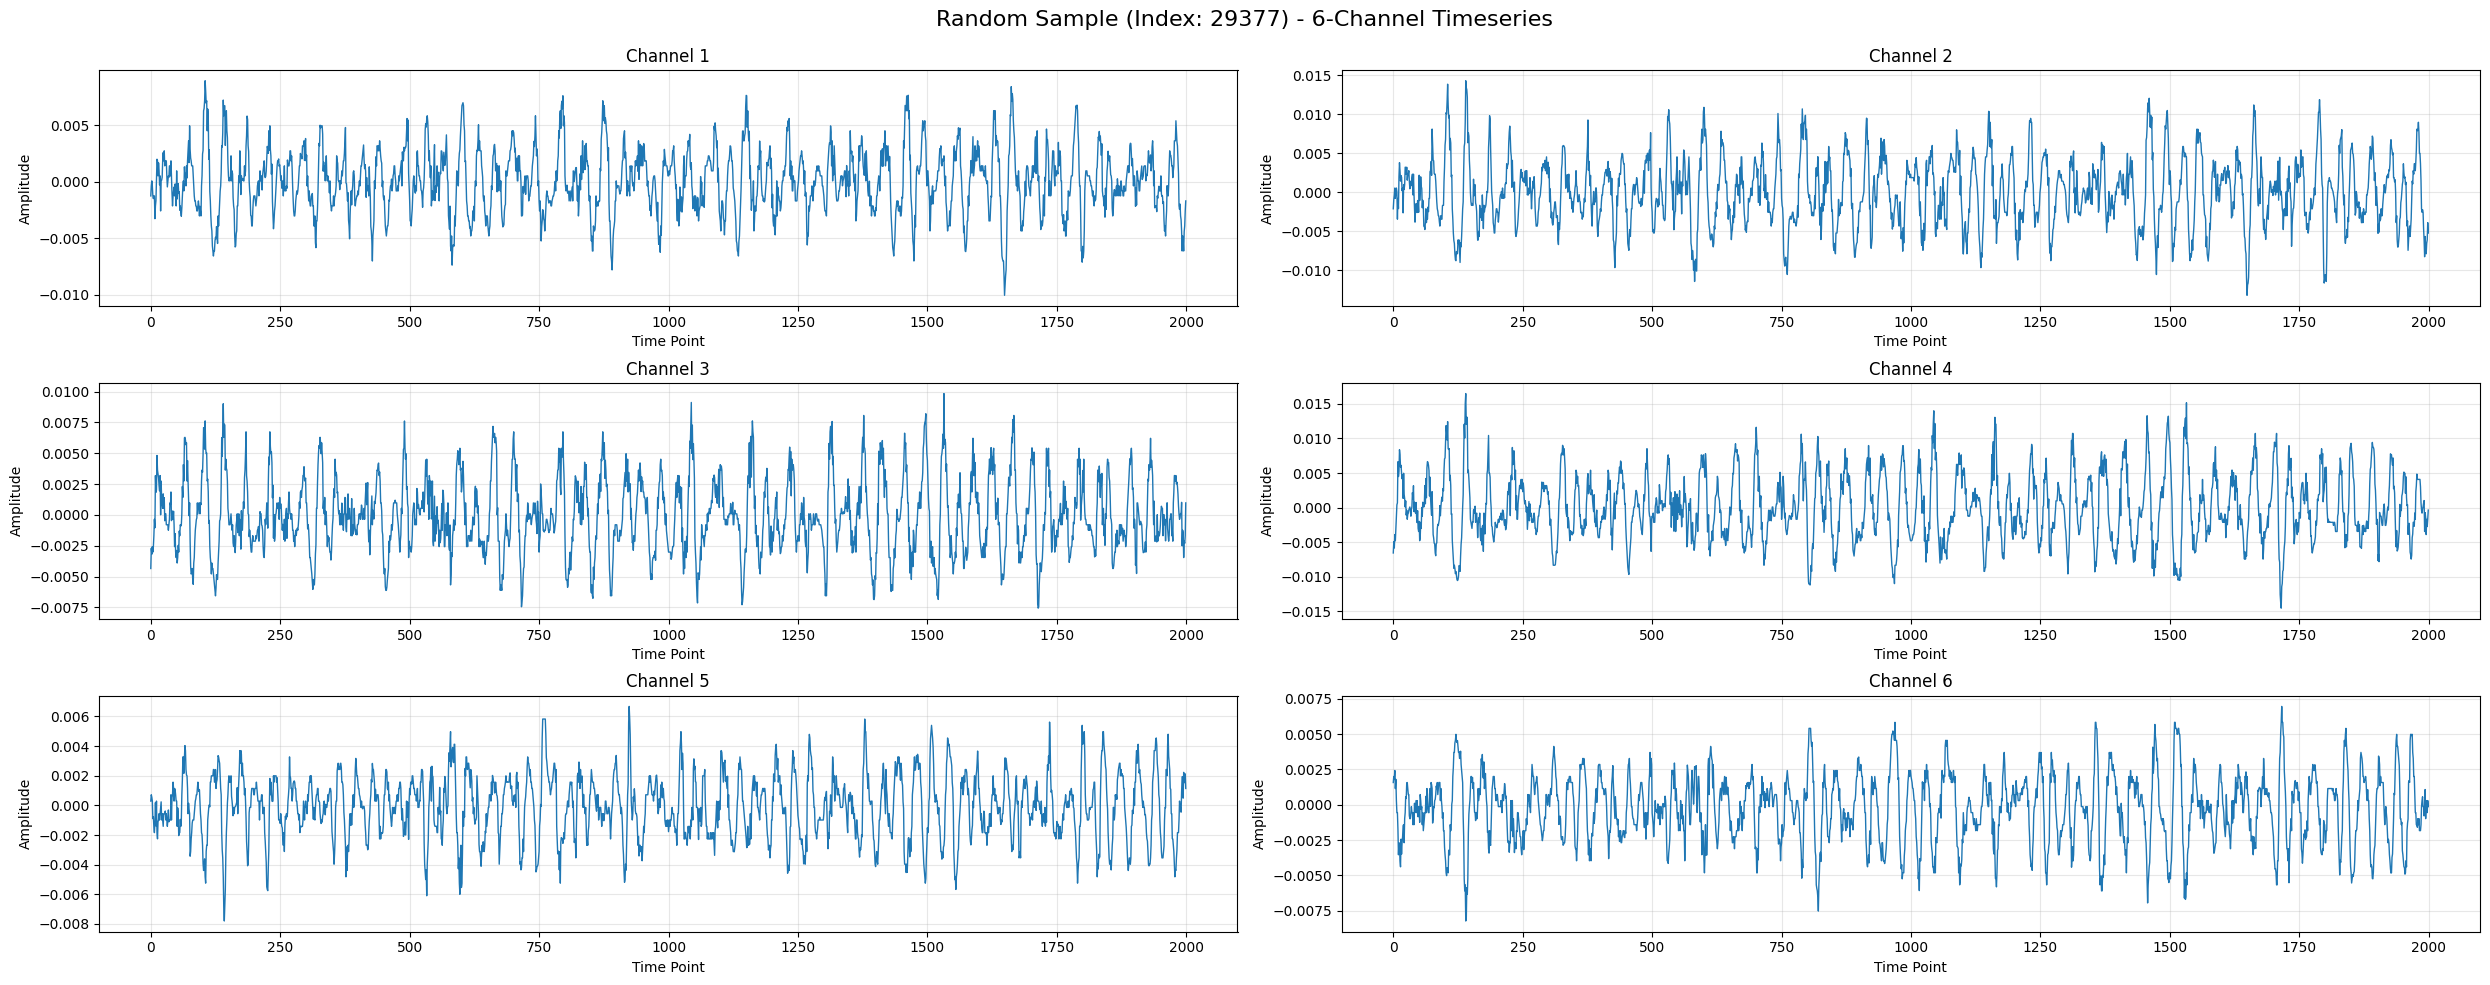

Displayed sample index: 29377
Sample shape: (6, 2000)


In [ ]:
X_normalized = np.load('X_normalized_i.npy', mmap_mode='r')
# Plot a random example from X_normalized to visualize the 6-channel timeseries

# Select a random sample index
random_idx = random.randint(0, X_normalized.shape[0] - 1)

# Get the sample data (6 channels, 2000 time points)
sample_data = X_normalized[random_idx]

# Create a figure with subplots for each channel
plt.figure(figsize=(25, 10))
channel_names = ['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 'Channel 5', 'Channel 6']

for i in range(6):
    plt.subplot(3, 2, i+1)
    plt.plot(sample_data[i], linewidth=1)
    plt.title(f'{channel_names[i]}')
    plt.xlabel('Time Point')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle(f'Random Sample (Index: {random_idx}) - 6-Channel Timeseries', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

print(f"Displayed sample index: {random_idx}")
print(f"Sample shape: {sample_data.shape}")


## Training Loop

In [5]:
train_ids = np.load('train_ids_5.npy')

X_normalized = np.load('X_normalized_i.npy', mmap_mode='r')
Y_normalized = np.load('Y_normalized_f.npy', mmap_mode='r')
ID = np.load('C_f.npy', mmap_mode='r')
FILE = np.load('F_f.npy', mmap_mode='r')
A = np.load('A_f.npy', mmap_mode='r')
S = np.load('S_f.npy', mmap_mode='r')
P = np.load('P_f.npy', mmap_mode='r')

# First create masks based on original IDs
train_mask = np.isin(ID, train_ids)

X_train_full = X_normalized[train_mask]
y_train_full = Y_normalized[train_mask]    
a_train_full = A[train_mask]
s_train_full = S[train_mask]
ID_train_full = ID[train_mask]
FILE_train_full = FILE[train_mask]

# Clear unnecessary variables
del X_normalized #, Y_normalized
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Get unique IDs for 5-fold cross-validation
unique_ids = np.unique(ID_train_full)
print(f"Total unique IDs: {len(unique_ids)}")

# Prepare for 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=2) #5

# Store the step sizes for each fold
fold_step_sizes = []

# Function to train a model for one fold
def train_fold(X_train, y_train, a_train, s_train, X_val, y_val, a_val, s_val, fold_num):
    # Create datasets and dataloaders
    train_dataset = ChunkedDataset(X_train, a_train, s_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)

    val_dataset = ChunkedDataset(X_val, a_val, s_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False)

    # Count number of cases for each label
    train_label_0 = np.sum(y_train[:, None] == 0)
    train_label_1 = np.sum(y_train[:, None] == 1)
    val_label_0 = np.sum(y_val[:, None] == 0)
    val_label_1 = np.sum(y_val[:, None] == 1)

    print(f"Fold {fold_num} - Training set - Label 0: {train_label_0}, Label 1: {train_label_1}")
    print(f"Fold {fold_num} - Validation set - Label 0: {val_label_0}, Label 1: {val_label_1}")

    epochs = 50
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CombinedGCNCNN(adj=adj).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0007, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    criterion = nn.BCELoss()

    best_val_auroc = 0
    best_model_state = None
    patience = 4
    early_stopping_counter = 0
    best_epoch = 0

    for epoch in range(epochs):
        clear_memory()
        model.train()
        running_loss = 0.0
        train_preds = []
        train_targets = []
        train_pbar = tqdm(train_loader, desc=f'Fold {fold_num} - Epoch {epoch+1}/{epochs} [Train]')
        optimizer.zero_grad()  # Zero gradients at start of epoch
        
        for batch_idx, (inputs, age, sex, targets) in enumerate(train_pbar):
            inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
            outputs = model(inputs, age, sex, adj)
            bce_loss = criterion(outputs, targets)

            l2_reg = 0.0
            for param in model.parameters():
                l2_reg += torch.norm(param, 2)
            
            reg_coef = 0.001  # Regularization coefficient
            loss = bce_loss + reg_coef * l2_reg
            loss.backward()

            train_preds.extend(outputs.detach().cpu().numpy())
            train_targets.extend(targets.detach().cpu().numpy())
            running_loss += loss.item()

            optimizer.step()
            optimizer.zero_grad()

            del inputs, age, sex, targets, outputs, loss, bce_loss, l2_reg
            clear_memory()
            train_pbar.set_postfix({'BCE': f'{running_loss/len(train_preds):.4f}'})
        
        # Calculate train metrics
        train_preds = np.array(train_preds)
        train_targets = np.array(train_targets)
        train_targets_binary = (train_targets > 0.5).astype(int)
        
        # Only calculate classification metrics if both classes are present
        train_metrics = {}
        if len(np.unique(train_targets_binary)) == 2:
            train_metrics['auroc'] = roc_auc_score(train_targets_binary, train_preds)
            train_metrics['auprc'] = average_precision_score(train_targets_binary, train_preds)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Fold {fold_num} - Epoch {epoch+1}/{epochs} [Val]')
            for inputs, age, sex, targets in val_pbar:
                inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
                outputs = model(inputs, age, sex, adj)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                val_preds.extend(outputs.detach().cpu().numpy())
                val_targets.extend(targets.detach().cpu().numpy())
                val_pbar.set_postfix({'BCE': f'{loss.item():.4f}'})
        
        # Calculate validation metrics
        val_preds = np.array(val_preds)
        val_targets = np.array(val_targets)
        val_targets_binary = val_targets
        
        val_metrics = {}
        if len(np.unique(val_targets_binary)) == 2:
            val_metrics['auroc'] = roc_auc_score(val_targets_binary, val_preds)
            val_metrics['auprc'] = average_precision_score(val_targets_binary, val_preds)
        
        epoch_val_loss = val_loss/len(val_loader)
        print(f"Fold {fold_num} - Epoch {epoch+1}/{epochs}")
        print(f"Train - BCE Loss: {running_loss/len(train_preds):.4f}, AUROC: {train_metrics.get('auroc', 0):.4f}, AUPRC: {train_metrics.get('auprc', 0):.4f}")
        print(f"Val   - BCE Loss: {epoch_val_loss:.4f}, AUROC: {val_metrics.get('auroc', 0):.4f}, AUPRC: {val_metrics.get('auprc', 0):.4f}")
        
        # Update learning rate
        scheduler.step(epoch_val_loss)
        
        # Save best model
        if val_metrics and (epoch == 0 or val_metrics['auroc'] > best_val_auroc):
            best_val_auroc = val_metrics['auroc']
            best_model_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            early_stopping_counter = 0  # Reset counter when we find a better model
            
            # Save the best model for this fold
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_auroc': best_val_auroc,
                'train_metrics': train_metrics,
                'val_metrics': val_metrics
            }, f'best_model_fold_{fold_num}.pth')
            print(f"New best model saved with validation AUROC: {best_val_auroc:.4f}")
        else:
            # Increment early stopping counter if validation AUROC didn't improve
            early_stopping_counter += 1
            
        # Check if early stopping criteria is met
        if early_stopping_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs. No improvement in validation AUROC for {patience} epochs.")
            break
    
    # Calculate the step size for this fold
    steps_per_epoch = len(train_loader)
    total_steps = (best_epoch + 1) * steps_per_epoch
    
    print(f"Fold {fold_num} training completed. Best validation AUROC: {best_val_auroc:.4f} at epoch {best_epoch+1}")
    print(f"Step size for fold {fold_num}: {total_steps}")
    
    return total_steps

# Perform 5-fold cross-validation
fold_num = 1
for train_idx, val_idx in kf.split(unique_ids):
    print(f"\n{'='*20} Fold {fold_num} {'='*20}")
    
    # Get the IDs for this fold
    fold_train_ids = unique_ids[train_idx]
    fold_val_ids = unique_ids[val_idx]
    
    # Create masks for this fold
    fold_train_mask = np.isin(ID_train_full, fold_train_ids)
    fold_val_mask = np.isin(ID_train_full, fold_val_ids)
    
    # Create the datasets for this fold
    X_fold_train = X_train_full[fold_train_mask]
    y_fold_train = y_train_full[fold_train_mask]
    a_fold_train = a_train_full[fold_train_mask]
    s_fold_train = s_train_full[fold_train_mask]
    
    X_fold_val = X_train_full[fold_val_mask]
    y_fold_val = y_train_full[fold_val_mask]
    a_fold_val = a_train_full[fold_val_mask]
    s_fold_val = s_train_full[fold_val_mask]
    
    # Train the model for this fold
    step_size = train_fold(
        X_fold_train, y_fold_train, a_fold_train, s_fold_train,
        X_fold_val, y_fold_val, a_fold_val, s_fold_val,
        fold_num
    )
    
    fold_step_sizes.append(step_size)
    fold_num += 1

# Calculate the mean step size across all folds
mean_step_size = int(np.mean(fold_step_sizes))
print(f"\nStep sizes for each fold: {fold_step_sizes}")
print(f"Mean step size: {mean_step_size}")

# Now train on the full training set for the mean number of steps
print(f"\n{'='*20} Training on Full Dataset {'='*20}")

# Create dataset and dataloader for full training set
full_train_dataset = ChunkedDataset(X_train_full, a_train_full, s_train_full, y_train_full)
full_train_loader = DataLoader(full_train_dataset, batch_size=BATCH, shuffle=True)

# Count number of cases for each label in full training set
full_train_label_0 = np.sum(y_train_full[:, None] == 0)
full_train_label_1 = np.sum(y_train_full[:, None] == 1)
print(f"Full training set - Label 0: {full_train_label_0}, Label 1: {full_train_label_1}")

# Calculate how many epochs to train for
steps_per_epoch = len(full_train_loader)
epochs_to_train = max(1, mean_step_size // steps_per_epoch)
remaining_steps = mean_step_size % steps_per_epoch

print(f"Training for {epochs_to_train} epochs and {remaining_steps} additional steps")

# Initialize model for full training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model = CombinedGCNCNN(adj=adj).to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=0.0007, weight_decay=1e-5)
criterion = nn.BCELoss()

# Train the model on the full dataset
final_model.train()
step_counter = 0
early_stop = False

for epoch in range(epochs_to_train + 1):  # +1 to handle remaining steps
    if early_stop:
        break
        
    train_pbar = tqdm(full_train_loader, desc=f'Full Training - Epoch {epoch+1}/{epochs_to_train+1}')
    running_loss = 0.0
    
    for batch_idx, (inputs, age, sex, targets) in enumerate(train_pbar):
        # Check if we've reached the target number of steps
        if step_counter >= mean_step_size:
            early_stop = True
            break
            
        inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = final_model(inputs, age, sex, adj)
        
        bce_loss = criterion(outputs, targets)
        l2_reg = 0.0
        for param in final_model.parameters():
            l2_reg += torch.norm(param, 2)
        
        reg_coef = 0.001
        loss = bce_loss + reg_coef * l2_reg
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        step_counter += 1
        
        # If we're in the last epoch, only process the remaining steps
        if epoch == epochs_to_train and batch_idx >= remaining_steps - 1:
            early_stop = True
            break
            
        train_pbar.set_postfix({'BCE': f'{running_loss/(batch_idx+1):.4f}', 'Step': f'{step_counter}/{mean_step_size}'})

# Save the final model
torch.save({
    'model_state_dict': final_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'steps_trained': step_counter,
    'mean_step_size': mean_step_size
}, 'final_model_full_training.pth')

print(f"Full training completed. Model trained for {step_counter} steps.")
print(f"Final model saved as 'final_model_full_training.pth'")

Total unique IDs: 536

==================== Fold 1 ====================
Fold 1 - Training set - Label 0: 7021, Label 1: 1550
Fold 1 - Validation set - Label 0: 1855, Label 1: 345


Fold 1 - Epoch 1/50 [Val]: 100%|██████████| 138/138 [00:01<00:00, 133.69it/s, BCE=1.6907]


Fold 1 - Epoch 1/50
Train - BCE Loss: 0.0471, AUROC: 0.6307, AUPRC: 0.2534
Val   - BCE Loss: 0.4795, AUROC: 0.6312, AUPRC: 0.2448
New best model saved with validation AUROC: 0.6312


Fold 1 - Epoch 2/50 [Val]: 100%|██████████| 138/138 [00:01<00:00, 137.58it/s, BCE=3.0434]


Fold 1 - Epoch 2/50
Train - BCE Loss: 0.0447, AUROC: 0.6792, AUPRC: 0.3223
Val   - BCE Loss: 0.4677, AUROC: 0.6459, AUPRC: 0.2383
New best model saved with validation AUROC: 0.6459


Fold 1 - Epoch 3/50 [Val]: 100%|██████████| 138/138 [00:00<00:00, 139.43it/s, BCE=0.8202]


Fold 1 - Epoch 3/50
Train - BCE Loss: 0.0452, AUROC: 0.6948, AUPRC: 0.3307
Val   - BCE Loss: 1.1791, AUROC: 0.7072, AUPRC: 0.3227
New best model saved with validation AUROC: 0.7072


Fold 1 - Epoch 4/50 [Val]: 100%|██████████| 138/138 [00:00<00:00, 151.42it/s, BCE=2.5255]


Fold 1 - Epoch 4/50
Train - BCE Loss: 0.0463, AUROC: 0.6619, AUPRC: 0.3119
Val   - BCE Loss: 0.4719, AUROC: 0.6780, AUPRC: 0.2167


Fold 1 - Epoch 5/50 [Val]: 100%|██████████| 138/138 [00:00<00:00, 155.66it/s, BCE=2.8044]


Fold 1 - Epoch 5/50
Train - BCE Loss: 0.0462, AUROC: 0.6716, AUPRC: 0.2965
Val   - BCE Loss: 0.4495, AUROC: 0.6505, AUPRC: 0.2149


Fold 1 - Epoch 6/50 [Val]: 100%|██████████| 138/138 [00:00<00:00, 150.34it/s, BCE=1.9800]


Fold 1 - Epoch 6/50
Train - BCE Loss: 0.0440, AUROC: 0.7351, AUPRC: 0.3639
Val   - BCE Loss: 0.4449, AUROC: 0.6630, AUPRC: 0.2243


Fold 1 - Epoch 7/50 [Val]: 100%|██████████| 138/138 [00:00<00:00, 162.74it/s, BCE=2.7875]


Fold 1 - Epoch 7/50
Train - BCE Loss: 0.0416, AUROC: 0.7868, AUPRC: 0.4484
Val   - BCE Loss: 0.4481, AUROC: 0.6461, AUPRC: 0.2087

Early stopping triggered after 7 epochs. No improvement in validation AUROC for 4 epochs.
Fold 1 training completed. Best validation AUROC: 0.7072 at epoch 3
Step size for fold 1: 1608

==================== Fold 2 ====================
Fold 2 - Training set - Label 0: 7103, Label 1: 1542
Fold 2 - Validation set - Label 0: 1773, Label 1: 353


Fold 2 - Epoch 1/50 [Val]: 100%|██████████| 133/133 [00:00<00:00, 152.23it/s, BCE=3.1522]


Fold 2 - Epoch 1/50
Train - BCE Loss: 0.0452, AUROC: 0.6683, AUPRC: 0.3031
Val   - BCE Loss: 0.4737, AUROC: 0.6582, AUPRC: 0.2599
New best model saved with validation AUROC: 0.6582


Fold 2 - Epoch 2/50 [Val]: 100%|██████████| 133/133 [00:00<00:00, 153.33it/s, BCE=1.9676]


Fold 2 - Epoch 2/50
Train - BCE Loss: 0.0424, AUROC: 0.7470, AUPRC: 0.3997
Val   - BCE Loss: 0.7489, AUROC: 0.7318, AUPRC: 0.3416
New best model saved with validation AUROC: 0.7318


Fold 2 - Epoch 3/50 [Val]: 100%|██████████| 133/133 [00:00<00:00, 135.42it/s, BCE=1.5824]


Fold 2 - Epoch 3/50
Train - BCE Loss: 0.0400, AUROC: 0.7955, AUPRC: 0.4652
Val   - BCE Loss: 1.3794, AUROC: 0.7315, AUPRC: 0.3272


Fold 2 - Epoch 4/50 [Val]: 100%|██████████| 133/133 [00:00<00:00, 167.07it/s, BCE=3.6404]


Fold 2 - Epoch 4/50
Train - BCE Loss: 0.0382, AUROC: 0.8343, AUPRC: 0.5416
Val   - BCE Loss: 0.4668, AUROC: 0.7031, AUPRC: 0.3129


Fold 2 - Epoch 5/50 [Val]: 100%|██████████| 133/133 [00:00<00:00, 156.08it/s, BCE=4.3301]


Fold 2 - Epoch 5/50
Train - BCE Loss: 0.0357, AUROC: 0.8708, AUPRC: 0.6290
Val   - BCE Loss: 0.6732, AUROC: 0.6594, AUPRC: 0.2506


Fold 2 - Epoch 6/50 [Val]: 100%|██████████| 133/133 [00:00<00:00, 133.58it/s, BCE=3.2627]


Fold 2 - Epoch 6/50
Train - BCE Loss: 0.0345, AUROC: 0.8896, AUPRC: 0.6578
Val   - BCE Loss: 0.5286, AUROC: 0.6641, AUPRC: 0.2502

Early stopping triggered after 6 epochs. No improvement in validation AUROC for 4 epochs.
Fold 2 training completed. Best validation AUROC: 0.7318 at epoch 2
Step size for fold 2: 1082

==================== Fold 3 ====================
Fold 3 - Training set - Label 0: 7172, Label 1: 1531
Fold 3 - Validation set - Label 0: 1704, Label 1: 364


Fold 3 - Epoch 1/50 [Val]: 100%|██████████| 130/130 [00:00<00:00, 145.54it/s, BCE=0.0904]


Fold 3 - Epoch 1/50
Train - BCE Loss: 0.0456, AUROC: 0.6454, AUPRC: 0.3156
Val   - BCE Loss: 0.6728, AUROC: 0.2757, AUPRC: 0.1460
New best model saved with validation AUROC: 0.2757


Fold 3 - Epoch 2/50 [Val]: 100%|██████████| 130/130 [00:00<00:00, 132.56it/s, BCE=0.3219]


Fold 3 - Epoch 2/50
Train - BCE Loss: 0.0483, AUROC: 0.4697, AUPRC: 0.1624
Val   - BCE Loss: 0.4932, AUROC: 0.4989, AUPRC: 0.2101
New best model saved with validation AUROC: 0.4989


Fold 3 - Epoch 3/50 [Val]: 100%|██████████| 130/130 [00:00<00:00, 143.29it/s, BCE=0.2111] 


Fold 3 - Epoch 3/50
Train - BCE Loss: 0.0471, AUROC: 0.5745, AUPRC: 0.2183
Val   - BCE Loss: 0.7843, AUROC: 0.6348, AUPRC: 0.2936
New best model saved with validation AUROC: 0.6348


Fold 3 - Epoch 4/50 [Val]: 100%|██████████| 130/130 [00:00<00:00, 206.95it/s, BCE=0.3396]


Fold 3 - Epoch 4/50
Train - BCE Loss: 0.0464, AUROC: 0.6330, AUPRC: 0.2504
Val   - BCE Loss: 1.2494, AUROC: 0.6945, AUPRC: 0.3126
New best model saved with validation AUROC: 0.6945


Fold 3 - Epoch 5/50 [Val]: 100%|██████████| 130/130 [00:00<00:00, 136.77it/s, BCE=0.2545]


Fold 3 - Epoch 5/50
Train - BCE Loss: 0.0453, AUROC: 0.6786, AUPRC: 0.2732
Val   - BCE Loss: 0.4735, AUROC: 0.7379, AUPRC: 0.3037
New best model saved with validation AUROC: 0.7379


Fold 3 - Epoch 6/50 [Val]: 100%|██████████| 130/130 [00:00<00:00, 144.24it/s, BCE=0.1445]


Fold 3 - Epoch 6/50
Train - BCE Loss: 0.0446, AUROC: 0.6845, AUPRC: 0.2694
Val   - BCE Loss: 0.4231, AUROC: 0.7502, AUPRC: 0.3191
New best model saved with validation AUROC: 0.7502


Fold 3 - Epoch 7/50 [Val]: 100%|██████████| 130/130 [00:01<00:00, 121.01it/s, BCE=0.0665]


Fold 3 - Epoch 7/50
Train - BCE Loss: 0.0440, AUROC: 0.6824, AUPRC: 0.2763
Val   - BCE Loss: 0.4391, AUROC: 0.7401, AUPRC: 0.3223


Fold 3 - Epoch 8/50 [Val]: 100%|██████████| 130/130 [00:00<00:00, 158.54it/s, BCE=75.0000] 


Fold 3 - Epoch 8/50
Train - BCE Loss: 0.0434, AUROC: 0.6820, AUPRC: 0.2677
Val   - BCE Loss: 70.7773, AUROC: 0.5140, AUPRC: 0.1803


Fold 3 - Epoch 9/50 [Val]: 100%|██████████| 130/130 [00:00<00:00, 137.34it/s, BCE=0.0485]


Fold 3 - Epoch 9/50
Train - BCE Loss: 0.0431, AUROC: 0.6807, AUPRC: 0.2669
Val   - BCE Loss: 0.4499, AUROC: 0.7417, AUPRC: 0.3242


Fold 3 - Epoch 10/50 [Val]: 100%|██████████| 130/130 [00:00<00:00, 130.83it/s, BCE=0.0583]


Fold 3 - Epoch 10/50
Train - BCE Loss: 0.0424, AUROC: 0.6894, AUPRC: 0.2789
Val   - BCE Loss: 0.4443, AUROC: 0.7056, AUPRC: 0.3044

Early stopping triggered after 10 epochs. No improvement in validation AUROC for 4 epochs.
Fold 3 training completed. Best validation AUROC: 0.7502 at epoch 6
Step size for fold 3: 3264

==================== Fold 4 ====================
Fold 4 - Training set - Label 0: 7038, Label 1: 1556
Fold 4 - Validation set - Label 0: 1838, Label 1: 339


Fold 4 - Epoch 1/50 [Val]: 100%|██████████| 137/137 [00:00<00:00, 145.68it/s, BCE=0.0000]


Fold 4 - Epoch 1/50
Train - BCE Loss: 0.0590, AUROC: 0.5505, AUPRC: 0.1994
Val   - BCE Loss: 0.4960, AUROC: 0.6936, AUPRC: 0.2789
New best model saved with validation AUROC: 0.6936


Fold 4 - Epoch 2/50 [Val]: 100%|██████████| 137/137 [00:00<00:00, 143.42it/s, BCE=100.0000]


Fold 4 - Epoch 2/50
Train - BCE Loss: 0.0439, AUROC: 0.7180, AUPRC: 0.3464
Val   - BCE Loss: 1.1445, AUROC: 0.7774, AUPRC: 0.4287
New best model saved with validation AUROC: 0.7774


Fold 4 - Epoch 3/50 [Val]: 100%|██████████| 137/137 [00:00<00:00, 157.83it/s, BCE=0.0000]


Fold 4 - Epoch 3/50
Train - BCE Loss: 0.0410, AUROC: 0.7878, AUPRC: 0.4431
Val   - BCE Loss: 0.3463, AUROC: 0.8060, AUPRC: 0.5670
New best model saved with validation AUROC: 0.8060


Fold 4 - Epoch 4/50 [Val]: 100%|██████████| 137/137 [00:00<00:00, 205.13it/s, BCE=9.1808]


Fold 4 - Epoch 4/50
Train - BCE Loss: 0.0387, AUROC: 0.8266, AUPRC: 0.5257
Val   - BCE Loss: 0.8752, AUROC: 0.8122, AUPRC: 0.4766
New best model saved with validation AUROC: 0.8122


Fold 4 - Epoch 5/50 [Val]: 100%|██████████| 137/137 [00:00<00:00, 245.32it/s, BCE=100.0000]


Fold 4 - Epoch 5/50
Train - BCE Loss: 0.0375, AUROC: 0.8492, AUPRC: 0.5705
Val   - BCE Loss: 1.1607, AUROC: 0.7480, AUPRC: 0.3431


Fold 4 - Epoch 6/50 [Val]: 100%|██████████| 137/137 [00:00<00:00, 152.69it/s, BCE=100.0000]


Fold 4 - Epoch 6/50
Train - BCE Loss: 0.0355, AUROC: 0.8865, AUPRC: 0.6432
Val   - BCE Loss: 1.1812, AUROC: 0.7255, AUPRC: 0.3187


Fold 4 - Epoch 7/50 [Val]: 100%|██████████| 137/137 [00:00<00:00, 156.42it/s, BCE=100.0000]


Fold 4 - Epoch 7/50
Train - BCE Loss: 0.0312, AUROC: 0.9301, AUPRC: 0.7664
Val   - BCE Loss: 1.1571, AUROC: 0.7378, AUPRC: 0.3119


Fold 4 - Epoch 8/50 [Val]: 100%|██████████| 137/137 [00:00<00:00, 147.77it/s, BCE=100.0000]


Fold 4 - Epoch 8/50
Train - BCE Loss: 0.0280, AUROC: 0.9546, AUPRC: 0.8431
Val   - BCE Loss: 1.1909, AUROC: 0.7514, AUPRC: 0.3782

Early stopping triggered after 8 epochs. No improvement in validation AUROC for 4 epochs.
Fold 4 training completed. Best validation AUROC: 0.8122 at epoch 4
Step size for fold 4: 2152

==================== Fold 5 ====================
Fold 5 - Training set - Label 0: 7170, Label 1: 1401
Fold 5 - Validation set - Label 0: 1706, Label 1: 494


Fold 5 - Epoch 1/50 [Val]: 100%|██████████| 138/138 [00:00<00:00, 185.79it/s, BCE=1.2157]


Fold 5 - Epoch 1/50
Train - BCE Loss: 0.0435, AUROC: 0.6821, AUPRC: 0.3132
Val   - BCE Loss: 0.8237, AUROC: 0.7049, AUPRC: 0.3680
New best model saved with validation AUROC: 0.7049


Fold 5 - Epoch 2/50 [Val]: 100%|██████████| 138/138 [00:00<00:00, 151.63it/s, BCE=0.0000]


Fold 5 - Epoch 2/50
Train - BCE Loss: 0.0425, AUROC: 0.7301, AUPRC: 0.3694
Val   - BCE Loss: 2.1886, AUROC: 0.3653, AUPRC: 0.1703


Fold 5 - Epoch 3/50 [Val]: 100%|██████████| 138/138 [00:00<00:00, 138.99it/s, BCE=0.2113]


Fold 5 - Epoch 3/50
Train - BCE Loss: 0.0443, AUROC: 0.7008, AUPRC: 0.3222
Val   - BCE Loss: 0.5443, AUROC: 0.6378, AUPRC: 0.3097


Fold 5 - Epoch 4/50 [Val]: 100%|██████████| 138/138 [00:00<00:00, 140.88it/s, BCE=0.0518]


Fold 5 - Epoch 4/50
Train - BCE Loss: 0.0456, AUROC: 0.6514, AUPRC: 0.2729
Val   - BCE Loss: 1.0548, AUROC: 0.5444, AUPRC: 0.2329


Fold 5 - Epoch 5/50 [Val]: 100%|██████████| 138/138 [00:00<00:00, 157.14it/s, BCE=0.0283]


Fold 5 - Epoch 5/50
Train - BCE Loss: 0.0458, AUROC: 0.6439, AUPRC: 0.2560
Val   - BCE Loss: 0.8740, AUROC: 0.6281, AUPRC: 0.2887

Early stopping triggered after 5 epochs. No improvement in validation AUROC for 4 epochs.
Fold 5 training completed. Best validation AUROC: 0.7049 at epoch 1
Step size for fold 5: 536

Step sizes for each fold: [1608, 1082, 3264, 2152, 536]
Mean step size: 1728

==================== Training on Full Dataset ====================
Full training set - Label 0: 8876, Label 1: 1895
Training for 2 epochs and 380 additional steps


Full Training - Epoch 3/3:  56%|█████▌    | 379/674 [00:09<00:07, 39.64it/s, BCE=0.7446, Step=1727/1728]


Full training completed. Model trained for 1728 steps.
Final model saved as 'final_model_full_training.pth'


## Inference

SR Youden Index : 0.0121
Training set - Label 0: 8876, Label 1: 1895


[Train]: 100%|██████████| 674/674 [00:01<00:00, 349.18it/s]


Youden Index : 0.2558


===== Evaluating on test_ids_1_new.npy =====
Test set - Label 0: 220, Label 1: 238


[Test]: 100%|██████████| 29/29 [00:00<00:00, 170.70it/s]


Fisher's Exact Test p-value: 0.478261
F1 Score: 0.2857 CI(95%): (0.0000, 0.5714)


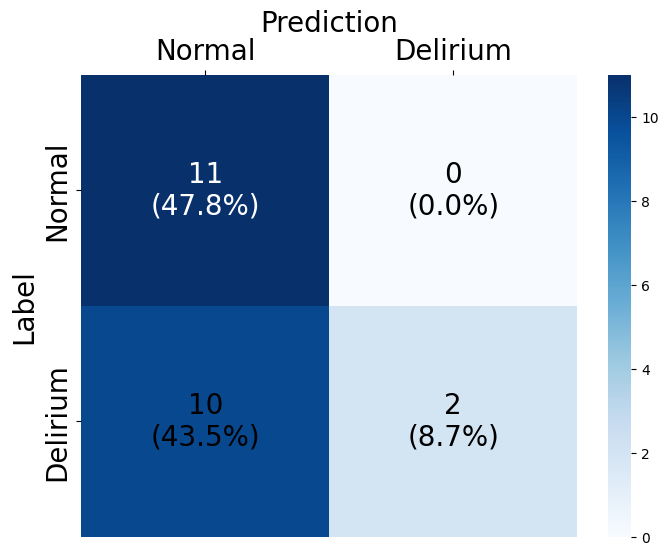

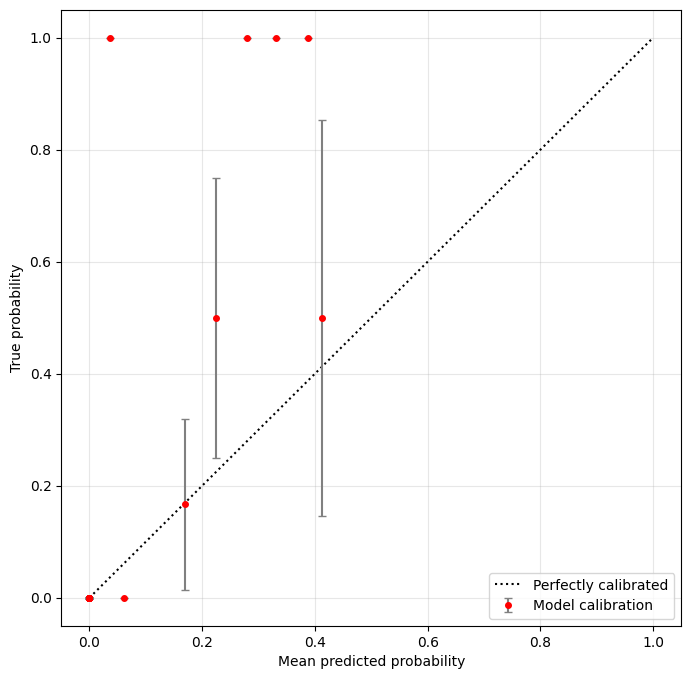

Fisher's Exact Test p-value: 0.009423
AUROC : 0.8106 CI(95%): (0.5769, 0.9924)
AUPRC: 0.8025 CI(95%): (0.5716, 0.9945)
F1 Score: 0.7619 CI(95%): (0.5000, 0.9333)
Test Accuracy: 78.26% CI(95%): (60.87%, 95.65%)
Brier Score: 0.2958 CI(95%): (0.1857, 0.4066)
ICI: 0.3789 CI(95%): (0.2760, 0.5384)


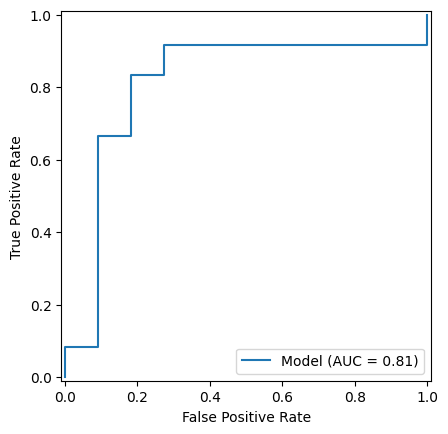

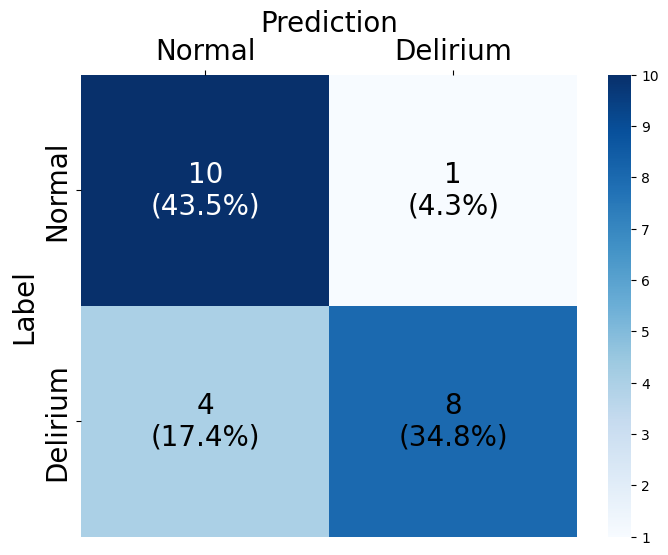

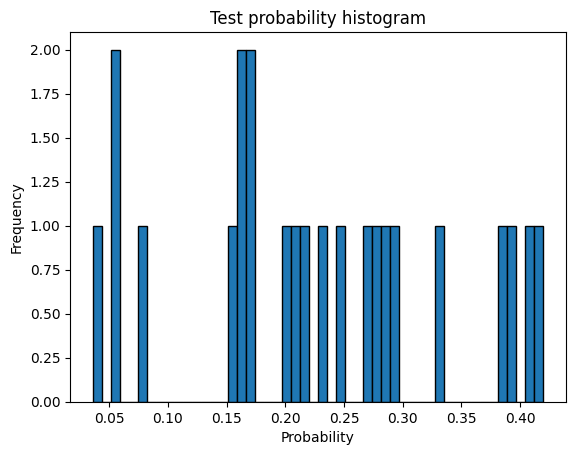



===== Evaluating on test_ids_2_new.npy =====
Test set - Label 0: 358, Label 1: 238


[Test]: 100%|██████████| 38/38 [00:00<00:00, 115.97it/s]


Fisher's Exact Test p-value: 0.151724
F1 Score: 0.2857 CI(95%): (0.0000, 0.5882)


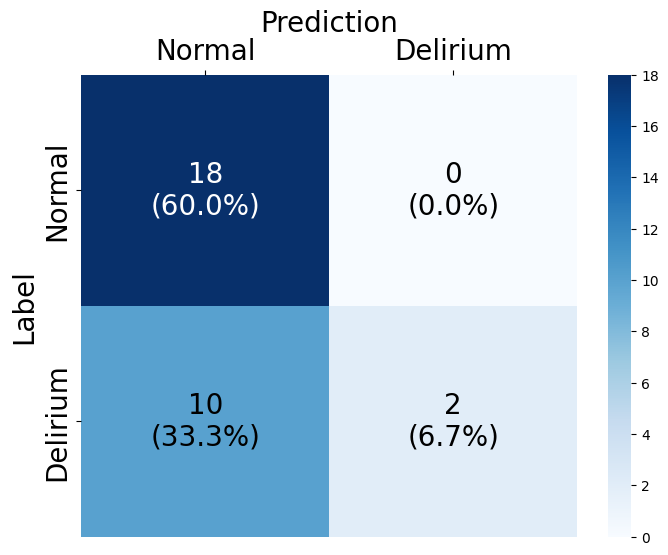

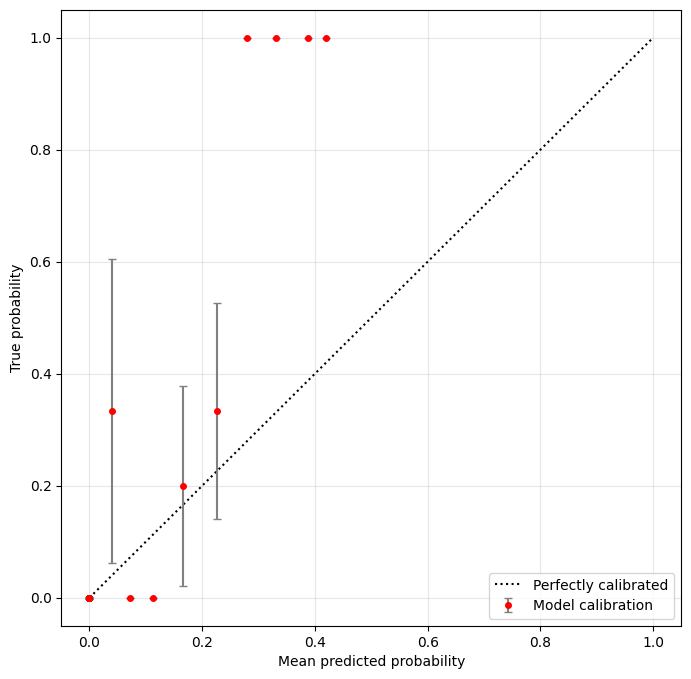

Fisher's Exact Test p-value: 0.000085
AUROC : 0.8750 CI(95%): (0.6851, 0.9952)
AUPRC: 0.8934 CI(95%): (0.7270, 0.9931)
F1 Score: 0.8000 CI(95%): (0.5455, 0.9565)
Test Accuracy: 86.67% CI(95%): (73.33%, 96.67%)
Brier Score: 0.2257 CI(95%): (0.1332, 0.3238)
ICI: 0.3207 CI(95%): (0.2313, 0.4500)


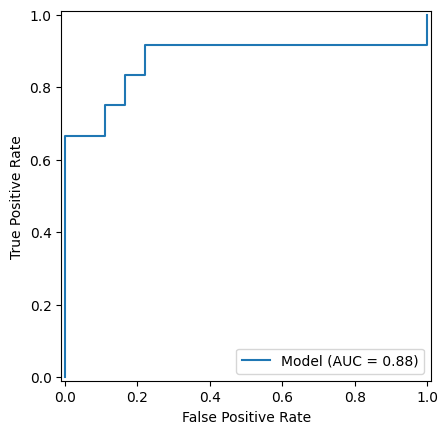

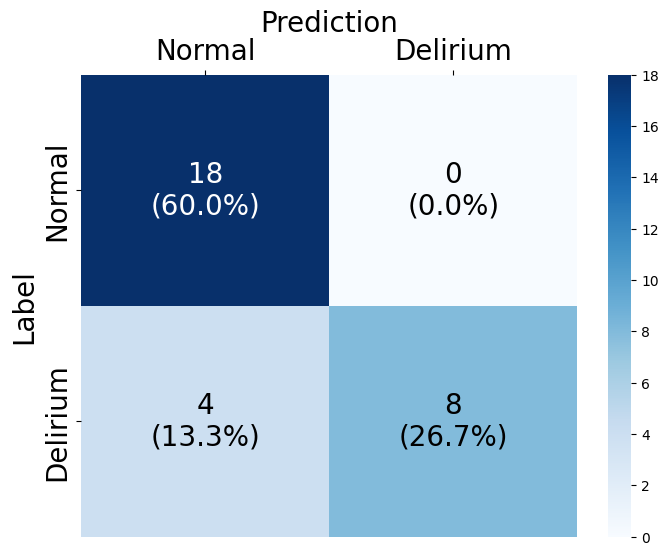

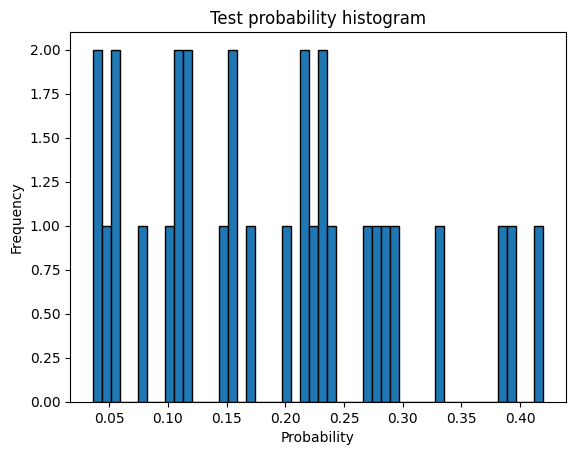



===== Evaluating on test_ids.npy =====
Test set - Label 0: 34446, Label 1: 238


[Test]: 100%|██████████| 2168/2168 [00:05<00:00, 392.62it/s]


Fisher's Exact Test p-value: 0.030570
F1 Score: 0.0741 CI(95%): (0.0000, 0.1818)


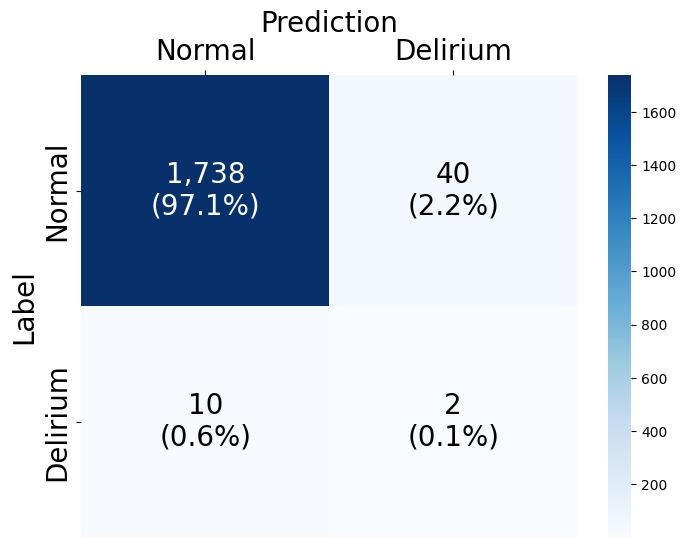

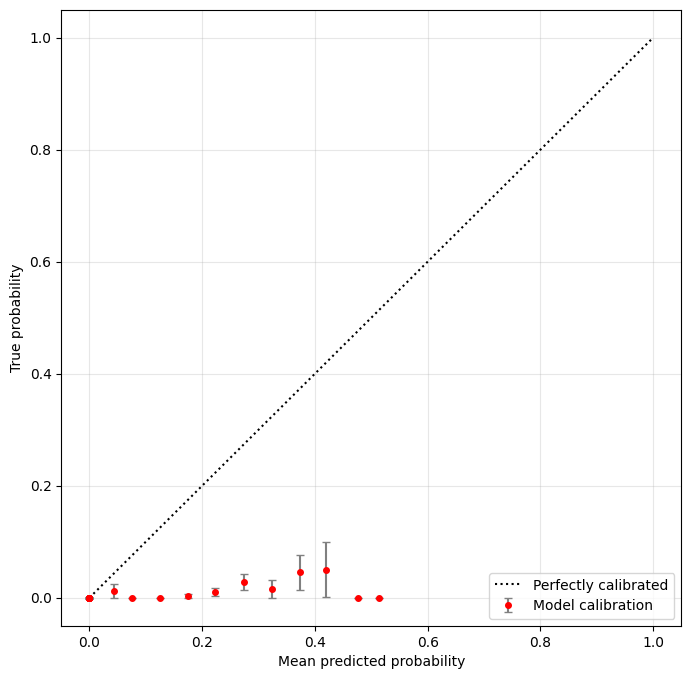

Fisher's Exact Test p-value: 0.000045
AUROC : 0.8169 CI(95%): (0.6416, 0.9278)
AUPRC: 0.0362 CI(95%): (0.0143, 0.0977)
F1 Score: 0.0599 CI(95%): (0.0235, 0.1024)
Test Accuracy: 85.99% CI(95%): (84.32%, 87.67%)
Brier Score: 0.0358 CI(95%): (0.0332, 0.0385)
ICI: 0.1505 CI(95%): (0.1453, 0.1559)


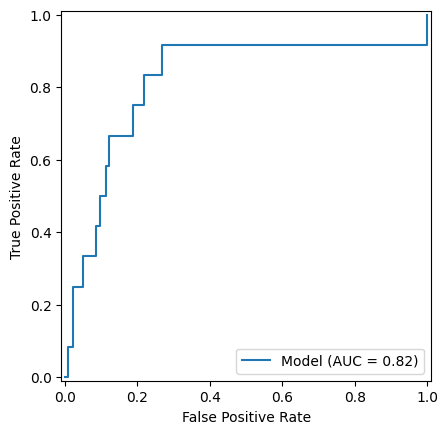

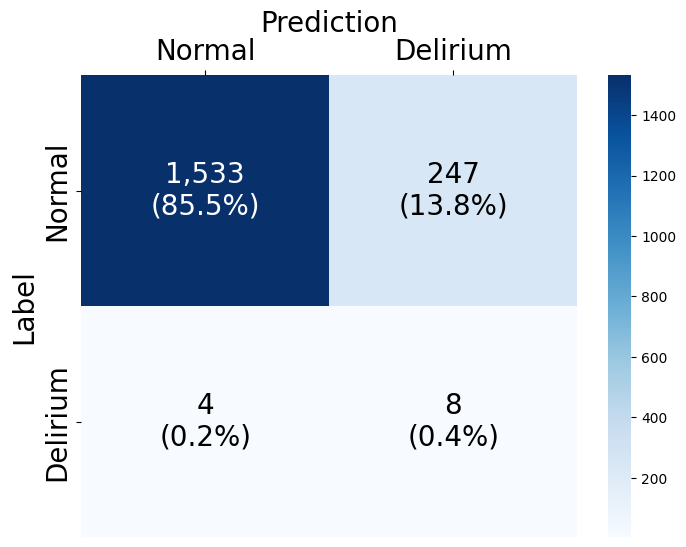

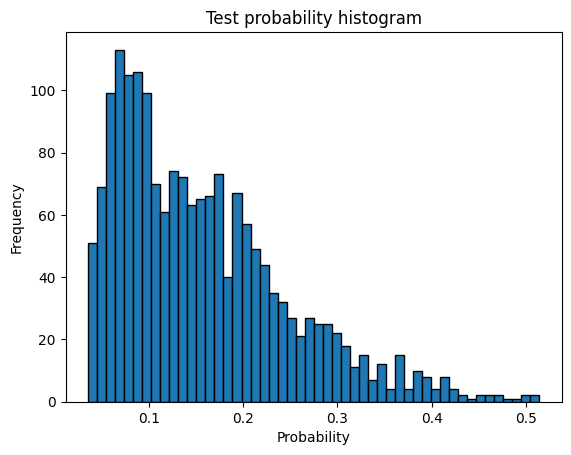

In [92]:
train_ids = np.load('train_ids_5.npy')
folds=5

X_normalized = np.load('X_normalized_i.npy', mmap_mode='r')
Y_normalized = np.load('Y_normalized_f.npy', mmap_mode='r')
ID = np.load('C_f.npy', mmap_mode='r')
FILE = np.load('F_f.npy', mmap_mode='r')
A = np.load('A_f.npy', mmap_mode='r')
S = np.load('S_f.npy', mmap_mode='r')
P = np.load('P_f.npy', mmap_mode='r')

# First create masks based on original IDs
train_mask = np.isin(ID, train_ids)

X_train = X_normalized[train_mask]
y_train = Y_normalized[train_mask]

# Clear unnecessary variables
del X_normalized #, Y_normalized
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
a_train = A[train_mask]
s_train = S[train_mask]
p_train = P[train_mask].copy()
#p_train[p_train == 0] = np.nan
ID_train = ID[train_mask]

valid_indices = ~np.isnan(p_train) #& (p_test != 0)
filtered_y_train = y_train[valid_indices]
filtered_p_train = p_train[valid_indices]
Youden_p = youden(filtered_y_train, filtered_p_train)
print(f'SR Youden Index : {Youden_p:.4f}')

orig_train_dataset = ChunkedDataset(X_train, a_train,s_train,y_train)
orig_train_loader = DataLoader(orig_train_dataset, batch_size=BATCH)

# Count number of cases for each label
train_label_0 = np.sum(y_train[:, None] == 0)
train_label_1 = np.sum(y_train[:, None] == 1)

print(f"Training set - Label 0: {train_label_0}, Label 1: {train_label_1}")

epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CombinedGCNCNN(adj=adj).to(device)
criterion = nn.BCELoss()  # Changed to Binary Cross Entropy
#############################################################################
X_normalized = np.load('X_normalized_i.npy', mmap_mode='r')
models = []
calib = mli.SplineCalib(unity_prior=False, unity_prior_weight=100, random_state=42, max_iter=500, logodds_scale=False)
#calib = IsotonicRegression(out_of_bounds='clip')

folds =1
for fold in range(folds):
    checkpoint = torch.load(f'final_model_full_training.pth')
    model = CombinedGCNCNN(adj=adj).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    models.append(model)

train_preds_all_models = []
train_targets = []

with torch.no_grad():
    train_pbar = tqdm(orig_train_loader, desc=f'[Train]')
    for inputs, age, sex, targets in train_pbar:
        inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
        
        # Get predictions from each model
        batch_preds = []
        for model in models:
            model.eval()
            outputs = model(inputs, age, sex, adj)
            batch_preds.append(outputs.detach().cpu().numpy())
        
        train_preds_all_models.extend(batch_preds[0].ravel())
        train_targets.extend(targets.detach().cpu().numpy())

train_preds = np.array(train_preds_all_models).ravel()
train_targets = np.array(train_targets).ravel()

Youden = youden(train_targets, train_preds)
calib.fit(train_preds, train_targets)
print(f'Youden Index : {Youden:.4f}')
del orig_train_loader

test_ids_files = ['test_ids_1_new.npy', 'test_ids_2_new.npy', 'test_ids.npy']
# Evaluate on each test set
for test_ids_file in test_ids_files:
    print(f"\n\n===== Evaluating on {test_ids_file} =====")
    
    # Load test IDs
    test_ids = np.load(test_ids_file, allow_pickle=True)
    # Create test mask and extract test data
    test_mask = np.isin(ID, test_ids)
    X_test = X_normalized[test_mask] 
    y_test = Y_normalized[test_mask]
    a_test = A[test_mask]
    s_test = S[test_mask]
    p_test = P[test_mask].copy()
    #p_test[p_test == 0] = np.nan
    
    # Create test dataset and loader
    test_dataset = ChunkedDataset(X_test,a_test,s_test,y_test)
    test_loader = DataLoader(test_dataset, batch_size=BATCH)
    del test_dataset
    
    test_label_0 = np.sum(y_test[:, None] == 0)
    test_label_1 = np.sum(y_test[:, None] == 1)
    print(f"Test set - Label 0: {test_label_0}, Label 1: {test_label_1}")
    
    test_preds_all_models = []
    test_targets = []
    
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc=f'[Test]')
        for inputs, age, sex, targets in test_pbar:
            inputs, age, sex, targets = inputs.to(device), age.to(device), sex.to(device), targets.to(device)
            
            batch_preds = []
            for model in models:
                model.eval()
                outputs = model(inputs, age, sex, adj)
                batch_preds.append(outputs.detach().cpu().numpy())
            
            test_preds_all_models.extend(batch_preds[0].ravel())
            test_targets.extend(targets.detach().cpu().numpy())
    
    # Calculate test metrics
    test_preds = np.array(test_preds_all_models)
    test_targets = np.array(test_targets)

    # Draw scatter plot between test_preds and p_test
    # Filter out indices where p_test is NaN or 0
    valid_indices = ~np.isnan(p_test) #& (p_test != 0)
    filtered_test_preds = test_preds[valid_indices]
    filtered_p_test = p_test[valid_indices]

    #draw_scatter_plot(filtered_p_test, filtered_test_preds)

    test_ids_expanded = FILE[test_mask]
    test_preds = calib.calibrate(test_preds)
    #test_preds = calib.transform(test_preds)
    unique_test_ids = np.unique(test_ids_expanded)
    averaged_test_preds = []
    averaged_test_targets = []
    averaged_p_test =[]

    for test_id in unique_test_ids:
        id_indices = np.where(test_ids_expanded == test_id)[0]
        if len(id_indices) > 0:  # Make sure we have predictions for this ID
            # Get all predictions for this ID and average them
            id_preds = test_preds[id_indices]
            id_p_test = p_test[id_indices]
            averaged_test_preds.append(np.mean(id_preds))
            averaged_p_test.append(np.nanmean(id_p_test))
            # All targets for same ID are identical, so just take the first one
            averaged_test_targets.append(test_targets[id_indices[0]])

    y_test = np.array(averaged_test_targets).ravel()
    y_test_proba = np.array(averaged_test_preds)
    p_test_mean = np.array(averaged_p_test)
    
    valid_indices = ~np.isnan(p_test_mean) #& (p_test != 0)
    filtered_y_test_proba = y_test_proba[valid_indices]
    filtered_y_test = y_test[valid_indices]
    filtered_p_test_mean = p_test_mean[valid_indices]

    #draw_scatter_plot(filtered_p_test_mean, filtered_y_test_proba)
    
    filtered_p_test_binary = (filtered_p_test_mean >= 5).astype(int) # np.median(filtered_p_test_mean)
    F1_score = f1_score(filtered_y_test.astype(int), filtered_p_test_binary)    
    # Create contingency table
    contingency_table = [
        [sum((filtered_y_test.astype(int) == 1) & (filtered_p_test_binary == 1)),  # True Positive
         sum((filtered_y_test.astype(int) == 1) & (filtered_p_test_binary == 0))], # False Negative
        [sum((filtered_y_test.astype(int) == 0) & (filtered_p_test_binary == 1)),  # False Positive
         sum((filtered_y_test.astype(int) == 0) & (filtered_p_test_binary == 0))]  # True Negative
    ]
    
    # Calculate Chi-square test if test_ids_file is 'test_ids.npy', otherwise Fisher's exact test

    odds_ratio, p_value = fisher_exact(contingency_table)
    print(f"Fisher's Exact Test p-value: {p_value:.6f}")

    ci_metrics = bootstrap_ci(filtered_y_test, filtered_p_test_mean, filtered_p_test_binary)

    print(f'F1 Score: {F1_score:.4f} CI(95%): ({ci_metrics["F1"][0]:.4f}, {ci_metrics["F1"][1]:.4f})')
    #if test_ids_file=='test_ids.npy':
    draw_confusion_matrix(filtered_y_test.ravel(), filtered_p_test_binary)
    
    draw_calibration_plot_with_error_bars(y_test, y_test_proba, n_bins=20)
    AUROC = roc_auc_score(y_test, y_test_proba)
    AUPRC = average_precision_score(y_test, y_test_proba)
    
    # Convert y_test_proba to binary predictions for F1 score calculation
    y_pred_test = (y_test_proba > Youden).astype(int)
    F1_score = f1_score(y_test, y_pred_test)

    # Create contingency table
    contingency_table = [
        [sum((y_test.astype(int) == 1) & (y_pred_test == 1)),  # True Positive
         sum((y_test.astype(int) == 1) & (y_pred_test == 0))], # False Negative
        [sum((y_test.astype(int) == 0) & (y_pred_test == 1)),  # False Positive
         sum((y_test.astype(int) == 0) & (y_pred_test == 0))]  # True Negative
    ]
    # Calculate Fisher's exact test
    odds_ratio, p_value = fisher_exact(contingency_table)
    print(f"Fisher's Exact Test p-value: {p_value:.6f}")
    
    brier_score = brier_score_loss(y_test, y_test_proba)
    ici = integrated_calibration_index(y_test, y_test_proba)
    ci_metrics = bootstrap_ci(y_test, y_test_proba, y_pred_test)
    print(f'AUROC : {AUROC:.4f} CI(95%): ({ci_metrics["AUROC"][0]:.4f}, {ci_metrics["AUROC"][1]:.4f})')
    print(f'AUPRC: {AUPRC:.4f} CI(95%): ({ci_metrics["AUPRC"][0]:.4f}, {ci_metrics["AUPRC"][1]:.4f})')
    print(f'F1 Score: {F1_score:.4f} CI(95%): ({ci_metrics["F1"][0]:.4f}, {ci_metrics["F1"][1]:.4f})')
    print(f'Test Accuracy: {round(100*accuracy_score(y_test, y_pred_test), 2)}% CI(95%): ({ci_metrics["Accuracy"][0]*100:.2f}%, {ci_metrics["Accuracy"][1]*100:.2f}%)')
    print(f'Brier Score: {brier_score:.4f} CI(95%): ({ci_metrics["Brier"][0]:.4f}, {ci_metrics["Brier"][1]:.4f})')
    print(f'ICI: {ici:.4f} CI(95%): ({ci_metrics["ICI"][0]:.4f}, {ci_metrics["ICI"][1]:.4f})')
    draw_roc_curve(y_test, y_test_proba)
    draw_confusion_matrix(y_test, y_pred_test)
    draw_y_test_proba(y_test_proba)
    
    # Clear memory
    torch.cuda.empty_cache()
    gc.collect()
    del test_loader